In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
import os
import matplotlib.pyplot as plt
import warnings
from google.colab import drive, files 
warnings.filterwarnings('ignore')

In [2]:
class EarlyStoppingByAccuracy(Callback):
    def __init__(self, threshold):
        super(EarlyStoppingByAccuracy, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc >= self.threshold:
            self.model.stop_training = True
            print(f"\nReached {self.threshold * 100}% validation accuracy. Stopping training.")

class BatchAccuracyLogger(Callback):
    def __init__(self):
        super(BatchAccuracyLogger, self).__init__()
        self.batch_accuracies = []

    def on_train_batch_end(self, batch, logs=None):
        train_acc = logs.get('accuracy')
        if train_acc is not None:
            self.batch_accuracies.append(train_acc)

    def plot_batch_accuracies(self):
        plt.figure(figsize=(12, 6))
        plt.plot(np.arange(len(self.batch_accuracies)), self.batch_accuracies)
        plt.title('Training Accuracy per Batch')
        plt.xlabel('Batch')
        plt.ylabel('Accuracy')
        plt.savefig('batch_accuracies.png', dpi=300)
        plt.show()

In [3]:
# Load and preprocess data
def load_and_preprocess_data(data_dir, image_height, image_width, batch_size):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_data = datagen.flow_from_directory(
        os.path.join(data_dir, 'Train'),
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='binary',
        classes=['Fake', 'Real']
    )

    val_datagen = ImageDataGenerator(rescale=1./255)
    val_data = val_datagen.flow_from_directory(
        os.path.join(data_dir, 'Valid'),
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='binary',
        classes=['Fake', 'Real']
    )
    print(data_dir)
    print(f"Found {train_data.samples} training samples.")
    print(f"Found {val_data.samples} validation samples.")
    return train_data, val_data

In [4]:
# Define the model architecture
def create_model(input_shape, random_state=42):
    tf.random.set_seed(random_state)
    
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

In [5]:
#Train the model
def train_model(model, train_data, val_data, epochs=50):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    early_stopping_loss = EarlyStopping(monitor='val_loss', patience=5, 
                                        restore_best_weights=True)
    early_stopping_accuracy = EarlyStoppingByAccuracy(threshold=0.99)
    batch_accuracy_logger = BatchAccuracyLogger()
    
    history = model.fit(train_data, epochs=epochs, validation_data=val_data, 
                        callbacks=[early_stopping_loss, early_stopping_accuracy, 
                                   batch_accuracy_logger], 
                        steps_per_epoch=train_data.samples // train_data.batch_size, 
                        validation_steps=val_data.samples // val_data.batch_size)
    
    return model, history, batch_accuracy_logger

Mounted at /content/drive
Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
/content/drive/MyDrive/Group_Project_Data/Group_Project_Data
Found 6000 training samples.
Found 2000 validation samples.
Epoch 1/50
187/187 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.9605
Reached 99.0% validation accuracy. Stopping training.
187/187 [==============================] - 1862s 10s/step - loss: 0.1001 - accuracy: 0.9605 - val_loss: 0.0167 - val_accuracy: 0.9965


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

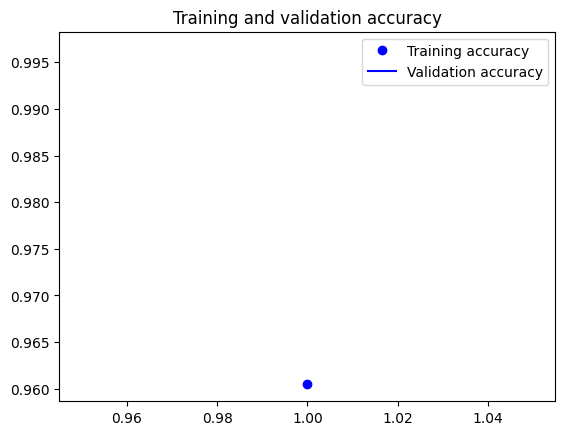

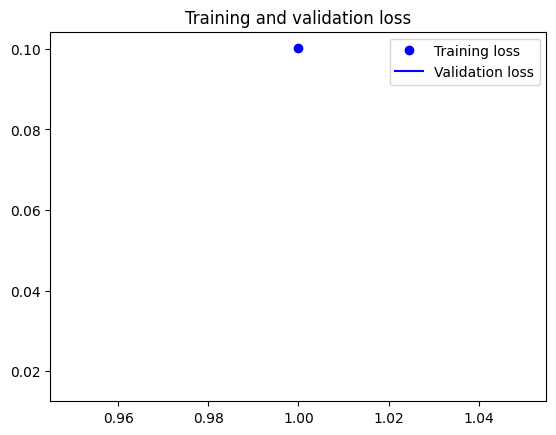

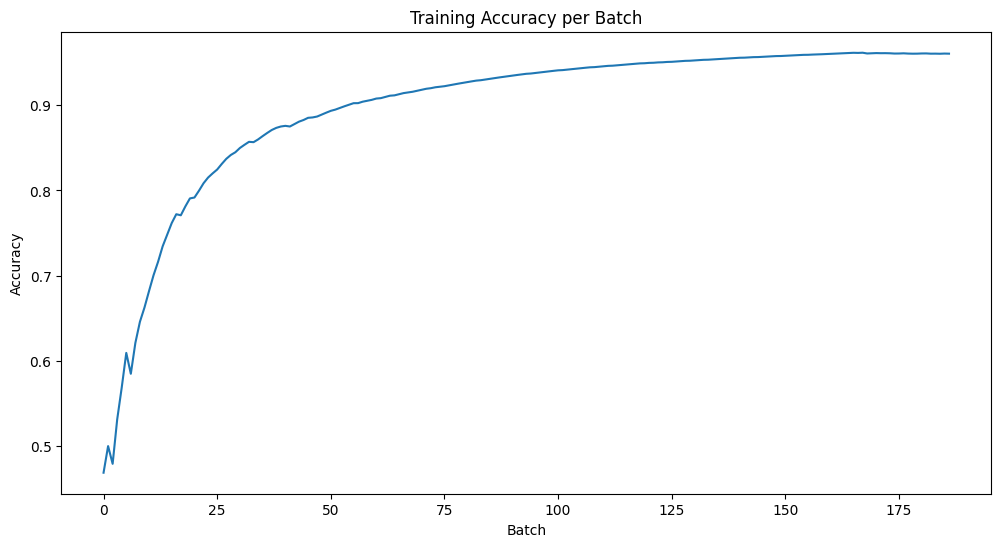

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 189ms/step
Prediction: real


<Figure size 640x480 with 0 Axes>

In [6]:
# Evaluate the model
def evaluate_model(model, test_data):
    test_loss, test_acc = model.evaluate(test_data, steps=test_data.samples // test_data.batch_size)
    print(f"Test accuracy: {test_acc:.2f}")

def predict_example(model, image_path, image_height, image_width):
    img = load_img(image_path, target_size=(image_height, image_width))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = img_array.reshape((1, image_height, image_width, 3))

    prediction = model.predict(img_array)
    return "real" if prediction[0][0] > 0.5 else "fake"

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig('training_validation_accuracy.png')  # Save the accuracy plot

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig('training_validation_loss.png')  # Save the loss plot

    plt.show()

def main():
    # Mount your Google Drive
    drive.mount('/content/drive')

    # Set the data directory (adjust the path according to your Google Drive structure)
    data_dir = "/content/drive/MyDrive/Group_Project_Data/Group_Project_Data"
    
    image_height, image_width, num_channels = 150, 150, 3
    batch_size = 32
    train_data, val_data = load_and_preprocess_data(data_dir, image_height, 
                                                    image_width, batch_size)
    input_shape = (image_height, image_width, num_channels)
    model = create_model(input_shape)
    model, history, batch_accuracy_logger = train_model(model, train_data, val_data)
    model.save('model.h5')
    
    # Download the trained model
    files.download('model.h5')
    
    # Plot training history
    plot_training_history(history)
    batch_accuracy_logger.plot_batch_accuracies()
    
    # Save and download the generated images
    plt.savefig('training_validation_accuracy.png')
    files.download('training_validation_accuracy.png')
    plt.savefig('training_validation_loss.png')
    files.download('training_validation_loss.png')
    plt.savefig('batch_accuracies.png')
    files.download('batch_accuracies.png')
    
    # Predict a single example
    image_path = os.path.join(data_dir, "Valid", "Real", "img_2.png")
    prediction = predict_example(model, image_path, image_height, image_width)
    print(f"Prediction: {prediction}")

if __name__ == '__main__':
    main()